# Google Stock Price Forecasting Using LSTM

## Library

In [ ]:
# Importing the libraries
import matplotlib.pyplot as plt
import datetime

import numpy as np # linear algebra
import pandas as pd # data processing,

from sklearn.preprocessing import MinMaxScaler

#Building the RNN
#Importing the Keras libraries and packages
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [ ]:
#dataset load 
dataset=pd.read_csv('Google_Stock_Price_Train.csv',index_col="Date",parse_dates=True)

##Explore Dataset

In [ ]:
#view 5 rows from dataset
dataset.head()

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,325.25,332.83,324.97,663.59,"7,380,500"
2012-01-04,331.27,333.87,329.08,666.45,"5,749,400"
2012-01-05,329.83,330.75,326.89,657.21,"6,590,300"
2012-01-06,328.34,328.77,323.68,648.24,"5,405,900"
2012-01-09,322.04,322.29,309.46,620.76,"11,688,800"


In [ ]:
# dataset information
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2012-01-03 to 2016-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1258 non-null   float64
 1   High    1258 non-null   float64
 2   Low     1258 non-null   float64
 3   Close   1258 non-null   object 
 4   Volume  1258 non-null   object 
dtypes: float64(3), object(2)
memory usage: 59.0+ KB


In [ ]:
#check null value in dataset
dataset.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

## Visualize

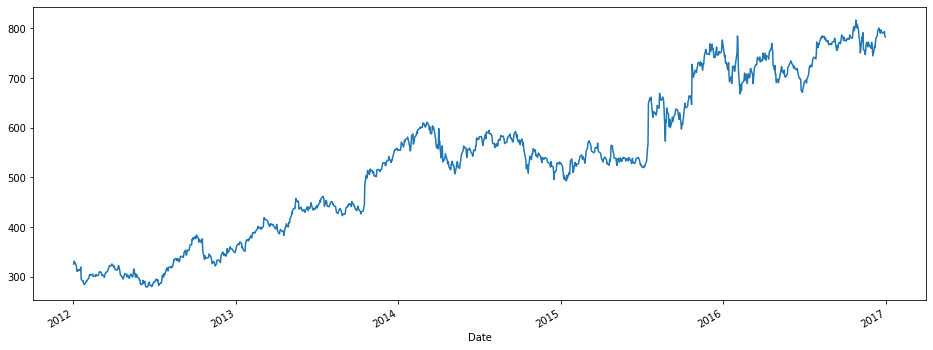

In [ ]:
#visualize the open data
dataset['Open'].plot(figsize=(16,6))

In [ ]:
# convert column "a" of a DataFrame
dataset["Close"] = dataset["Close"].str.replace(',', '').astype(float)

In [ ]:
dataset["Volume"] = dataset["Volume"].str.replace(',', '').astype(float)

In [ ]:
# 7 day rolling mean
dataset.rolling(7).mean().head(20)

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,NaN,NaN,NaN,NaN,NaN
2012-01-04,NaN,NaN,NaN,NaN,NaN
2012-01-05,NaN,NaN,NaN,NaN,NaN
2012-01-06,NaN,NaN,NaN,NaN,NaN
2012-01-09,NaN,NaN,NaN,NaN,NaN
2012-01-10,NaN,NaN,NaN,NaN,NaN
2012-01-11,323.002857,325.392857,318.682857,643.132857,7.208100e+06
2012-01-12,321.457143,322.882857,316.841429,638.037143,6.691514e+06
2012-01-13,318.698571,319.801429,314.025714,631.870000,6.531857e+06


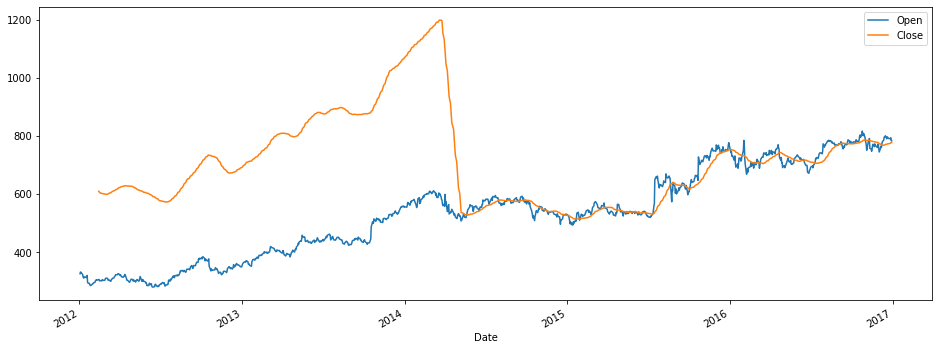

In [ ]:
#visualize the open and the close data
dataset['Open'].plot(figsize=(16,6))
dataset.rolling(window=30).mean()['Close'].plot()
plt.legend()

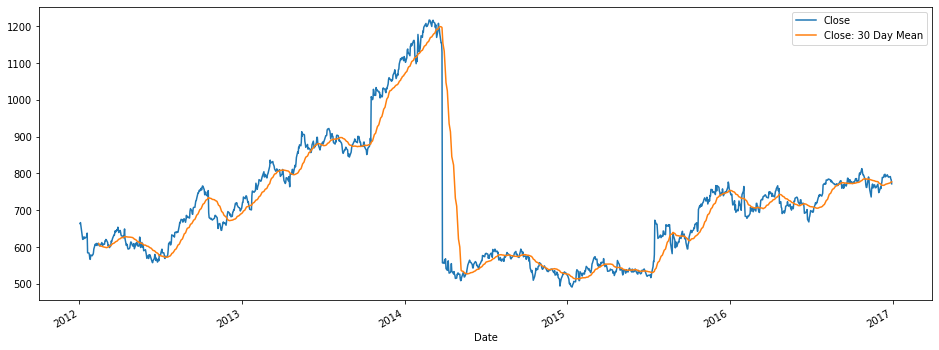

In [ ]:
#visualize the close data and rolling mean 30 days close data
dataset['Close: 30 Day Mean'] = dataset['Close'].rolling(window=30).mean()
dataset[['Close','Close: 30 Day Mean']].plot(figsize=(16,6))

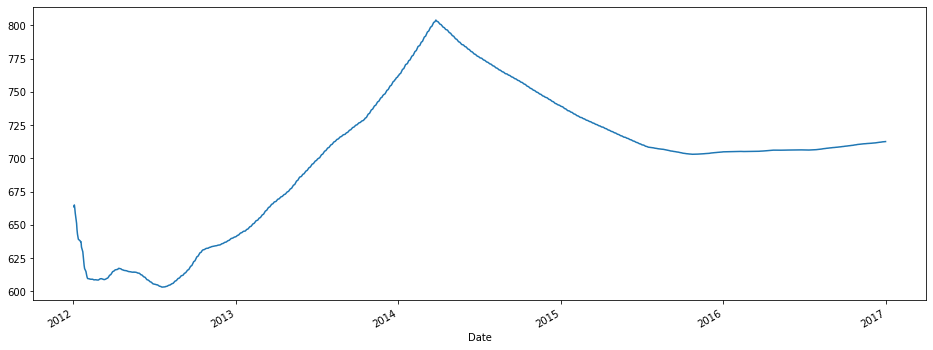

In [ ]:
# Optional specify a minimum number of periods
dataset['Close'].expanding(min_periods=1).mean().plot(figsize=(16,6))

## Feature Engineering

In [ ]:
#define the training_set 
training_set=dataset['Open']
training_set=pd.DataFrame(training_set)

In [ ]:
#training_set head
training_set.head(3)

,Open
Date,
2012-01-03,325.25
2012-01-04,331.27
2012-01-05,329.83


In [ ]:
# Feature Scaling

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, 1258):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
  #split the data train and validation for our model
  split_size = int(len(X_train)*(0.8)) # this will default to 80% train/20% test
  train_windows = X_train[:split_size]
  train_labels = y_train[:split_size]
  test_windows = X_train[split_size:]
  test_labels = y_train[split_size:]
  len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(958, 240, 958, 240)

In [ ]:
#train window and test window shape
train_windows.shape, test_windows.shape

((958, 60, 1), (240, 60, 1))

## LSTM Model

In [ ]:
#create a funtion to implement a ModelCheckpoint callback with a spesific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath= os.path.join(save_path,model_name), # create filepath to save model
                                            verbose=0, #only output a limited amount of text
                                            save_best_only=True) #save only the best model to file

In [ ]:
# Initialising the RNN
model = Sequential()

In [ ]:
# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(200, activation='relu', input_shape=(train_windows.shape[1], train_windows.shape[2])))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(1))

In [ ]:
# Compiling the RNN
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# Fitting the RNN to the Training set
epoch = 100 
batch_size = 32
model.fit(train_windows, train_labels, 
          epochs=epoch, 
          batch_size=batch_size, 
          validation_data=(test_windows, test_labels), 
          verbose=1, 
          shuffle=False,
          callbacks=[create_model_checkpoint(model_name=model.name)])

Epoch 1/100
30/30 [==============================] - ETA: 0s - loss: 0.0114INFO:tensorflow:Assets written to: model_experiments/sequential/assets


30/30 [==============================] - 8s 224ms/step - loss: 0.0114 - val_loss: 0.0086
Epoch 2/100
30/30 [==============================] - 4s 137ms/step - loss: 0.0443 - val_loss: 0.0284
Epoch 3/100
30/30 [==============================] - ETA: 0s - loss: 0.0087INFO:tensorflow:Assets written to: model_experiments/sequential/assets


INFO:tensorflow:Assets written to: model_experiments/sequential/assets


30/30 [==============================] - 6s 204ms/step - loss: 0.0087 - val_loss: 0.0015
Epoch 4/100
30/30 [==============================] - 4s 118ms/step - loss: 0.0070 - val_loss: 0.0017
Epoch 5/100
30/30 [==============================] - ETA: 0s - loss: 0.0063INFO:tensorflow:Assets written to: model_experiments/sequential/assets


INFO:tensorflow:Assets written to: model_experiments/sequential/assets


30/30 [==============================] - 6s 203ms/step - loss: 0.0063 - val_loss: 0.0010
Epoch 6/100
30/30 [==============================] - 4s 118ms/step - loss: 0.0089 - val_loss: 0.0163
Epoch 7/100
30/30 [==============================] - 4s 121ms/step - loss: 0.0118 - val_loss: 0.0025
Epoch 8/100
30/30 [==============================] - 3s 117ms/step - loss: 0.0129 - val_loss: 0.0123
Epoch 9/100
30/30 [==============================] - 4s 119ms/step - loss: 0.0182 - val_loss: 0.0050
Epoch 10/100
30/30 [==============================] - 4s 121ms/step - loss: 0.0108 - val_loss: 0.0094
Epoch 11/100
30/30 [==============================] - ETA: 0s - loss: 0.0091INFO:tensorflow:Assets written to: model_experiments/sequential/assets


INFO:tensorflow:Assets written to: model_experiments/sequential/assets


30/30 [==============================] - 6s 215ms/step - loss: 0.0091 - val_loss: 7.5061e-04
Epoch 12/100
30/30 [==============================] - 4s 122ms/step - loss: 0.0096 - val_loss: 0.0109
Epoch 13/100
30/30 [==============================] - 4s 119ms/step - loss: 0.0156 - val_loss: 0.0125
Epoch 14/100
30/30 [==============================] - 4s 119ms/step - loss: 0.0078 - val_loss: 0.0012
Epoch 15/100
30/30 [==============================] - 4s 120ms/step - loss: 1344624740270080.0000 - val_loss: 0.0021
Epoch 16/100
30/30 [==============================] - ETA: 0s - loss: 0.0086INFO:tensorflow:Assets written to: model_experiments/sequential/assets


INFO:tensorflow:Assets written to: model_experiments/sequential/assets


30/30 [==============================] - 6s 204ms/step - loss: 0.0086 - val_loss: 7.3737e-04
Epoch 17/100
30/30 [==============================] - 4s 119ms/step - loss: 0.0060 - val_loss: 0.0020
Epoch 18/100
30/30 [==============================] - 4s 119ms/step - loss: 0.0060 - val_loss: 9.9652e-04
Epoch 19/100
30/30 [==============================] - 4s 150ms/step - loss: 0.0077 - val_loss: 0.0026
Epoch 20/100
30/30 [==============================] - ETA: 0s - loss: 0.0064INFO:tensorflow:Assets written to: model_experiments/sequential/assets


INFO:tensorflow:Assets written to: model_experiments/sequential/assets


30/30 [==============================] - 6s 205ms/step - loss: 0.0064 - val_loss: 5.8068e-04
Epoch 21/100
30/30 [==============================] - 5s 171ms/step - loss: 0.0070 - val_loss: 0.0055
Epoch 22/100
30/30 [==============================] - 3s 115ms/step - loss: 0.0120 - val_loss: 0.0065
Epoch 23/100
30/30 [==============================] - 3s 115ms/step - loss: 0.0067 - val_loss: 0.0012
Epoch 24/100
30/30 [==============================] - 3s 116ms/step - loss: 0.0053 - val_loss: 6.2621e-04
Epoch 25/100
30/30 [==============================] - 3s 115ms/step - loss: 0.0074 - val_loss: 0.0028
Epoch 26/100
30/30 [==============================] - 3s 116ms/step - loss: 0.0096 - val_loss: 0.0084
Epoch 27/100
30/30 [==============================] - 4s 118ms/step - loss: 0.0045 - val_loss: 9.1598e-04
Epoch 28/100
30/30 [==============================] - 4s 117ms/step - loss: 0.0049 - val_loss: 9.5242e-04
Epoch 29/100
30/30 [==============================] - 3s 116ms/step - loss: 0.0

INFO:tensorflow:Assets written to: model_experiments/sequential/assets


30/30 [==============================] - 6s 212ms/step - loss: 0.0057 - val_loss: 5.3742e-04
Epoch 32/100
30/30 [==============================] - 3s 117ms/step - loss: 0.0107 - val_loss: 9.1131e-04
Epoch 33/100
30/30 [==============================] - 4s 118ms/step - loss: 0.0126 - val_loss: 8.0898e-04
Epoch 34/100
30/30 [==============================] - 4s 118ms/step - loss: 0.0091 - val_loss: 7.4183e-04
Epoch 35/100
30/30 [==============================] - 4s 120ms/step - loss: 0.0158 - val_loss: 0.0134
Epoch 36/100
30/30 [==============================] - 4s 120ms/step - loss: 0.0180 - val_loss: 0.0036
Epoch 37/100
30/30 [==============================] - 4s 117ms/step - loss: 0.0123 - val_loss: 8.9376e-04
Epoch 38/100
30/30 [==============================] - 4s 118ms/step - loss: 0.0081 - val_loss: 6.1745e-04
Epoch 39/100
30/30 [==============================] - 4s 118ms/step - loss: 0.0151 - val_loss: 0.0483
Epoch 40/100
30/30 [==============================] - 4s 119ms/step - l

In [ ]:
# Load in best version of model 5 and evaluate on the test data
model_save = tf.keras.models.load_model("model_experiments/sequential/")
model_save.evaluate(test_windows, test_labels)

8/8 [==============================] - 1s 37ms/step - loss: 5.3742e-04


0.0005374207976274192

## Evaluate The Model with Dataset Test

In [ ]:
# Making the predictions and visualising the results
# Getting the real stock price of 2017
dataset_test = pd.read_csv('/content/drive/MyDrive/Tensorflow Kominfo/Time Series/Assignment/Google_Stock_Price_Test.csv',index_col="Date",parse_dates=True)

In [ ]:
real_stock_price = dataset_test.iloc[:, 1:2].values

In [ ]:
dataset_test["Volume"] = dataset_test["Volume"].str.replace(',', '').astype(float)

In [ ]:
#dataset_test head
dataset_test.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,778.81,789.63,775.80,786.14,1657300.0
2017-01-04,788.36,791.34,783.16,786.90,1073000.0
2017-01-05,786.08,794.48,785.02,794.02,1335200.0
2017-01-06,795.26,807.90,792.20,806.15,1640200.0
2017-01-09,806.40,809.97,802.83,806.65,1272400.0


In [ ]:
test_set=dataset_test['Open']
test_set=pd.DataFrame(test_set)

In [ ]:
#data test information
test_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20 entries, 2017-01-03 to 2017-01-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    20 non-null     float64
dtypes: float64(1)
memory usage: 320.0 bytes


In [ ]:
# Getting the predicted stock price of 2017
dataset_total = pd.concat((dataset['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model_save.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
predicted_stock_price=pd.DataFrame(predicted_stock_price)
predicted_stock_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       20 non-null     float32
dtypes: float32(1)
memory usage: 208.0 bytes


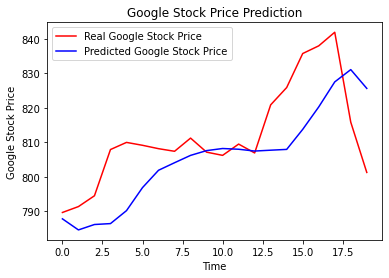

In [ ]:
# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()


In [ ]:
def evaluate_preds(y_true, y_pred):
  # Make the metric calculations
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)

  # Account for different sized metrics
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()
          }

In [ ]:
#evaluate prediction resul
evaluate_preds(y_true = real_stock_price, y_pred= predicted_stock_price)

{'mae': 10.729792, 'mape': 1.3141121, 'mse': 176.88316, 'rmse': 10.729792}

In [ ]:
model.save('Google_Stock_Forecasting_LSTM.h5')